In [1]:
%reload_ext autoreload
%autoreload 2

from fastai import *
from fastai.vision import *
from fastai.vision.models.wrn import wrn_22
from fastai.docs import *
from fastai.docs import CIFAR_PATH

torch.backends.cudnn.benchmark = True

### Model Definition

In [2]:
# --
# Model definition
# Derived from models in `https://github.com/kuangliu/pytorch-cifar`

class PreActBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        
        self.bn1   = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)
            )
    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        return out + shortcut
    
class ResNet18(nn.Module):
    def __init__(self, num_blocks=[2, 2, 2, 2], num_classes=10):
        super().__init__()
        self.in_channels = 64
        self.prep = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.layers = nn.Sequential(
            self._make_layer(64, 64, num_blocks[0], stride=1),
            self._make_layer(64, 128, num_blocks[1], stride=2),
            self._make_layer(128, 256, num_blocks[2], stride=2),
            self._make_layer(256, 256, num_blocks[3], stride=2),
        )
        self.classifier = nn.Linear(512, num_classes)
        
    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        
        strides = [stride] + [1] * (num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(PreActBlock(in_channels=in_channels, out_channels=out_channels, stride=stride))
            in_channels = out_channels
        
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = x.half()
        x = self.prep(x)
        
        x = self.layers(x)
        
        x_avg = F.adaptive_avg_pool2d(x, (1, 1))
        x_avg = x_avg.view(x_avg.size(0), -1)
        
        x_max = F.adaptive_max_pool2d(x, (1, 1))
        x_max = x_max.view(x_max.size(0), -1)
        
        x = torch.cat([x_avg, x_max], dim=-1)
        
        x = self.classifier(x)
        
        return x

In [3]:
untar_data(CIFAR_PATH)

In [4]:
ds_tfms = ([pad(padding=4), crop(size=32, row_pct=(0,1), col_pct=(0,1)), flip_lr(p=0.5)], [])
data = image_data_from_folder(CIFAR_PATH, valid='test', ds_tfms=ds_tfms, tfms=cifar_norm, bs=512)

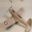

In [8]:
data.train_ds[1][0]

In [ ]:
# show_image_batch(data.train_dl, data.train_ds.classes)

In [6]:
learn = Learner(data, ResNet18(), metrics=accuracy).to_fp16()
learn.opt_fn = optim.SGD
learn.fit_one_cycle(30, 2e-1, wd=5e-4, div_factor=20, pct_start=0.5)

Total time: 04:19
epoch  train loss  valid loss  accuracy
0      1.530416    1.379568    0.493400  (00:08)
1      1.130145    1.396219    0.556300  (00:08)
2      0.885574    1.133361    0.628200  (00:08)
3      0.736106    0.775118    0.730000  (00:08)
4      0.624078    0.717389    0.765100  (00:08)
5      0.563536    0.665837    0.779500  (00:08)
6      0.494436    0.568151    0.811600  (00:08)
7      0.454518    0.592833    0.807900  (00:08)
8      0.420526    0.624459    0.805100  (00:08)
9      0.377837    0.466691    0.845000  (00:08)
10     0.357294    0.465187    0.846000  (00:08)
11     0.327962    0.480546    0.846000  (00:08)
12     0.299309    0.580033    0.810400  (00:08)
13     0.277412    0.371445    0.878400  (00:08)
14     0.262845    0.408074    0.867700  (00:08)
15     0.250052    0.456760    0.859100  (00:08)
16     0.235815    0.386383    0.876700  (00:08)
17     0.218311    0.394265    0.877600  (00:08)
18     0.196647    0.348167    0.890900  (00:08)
19     0.18

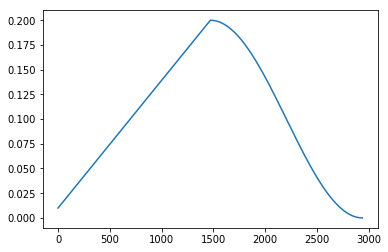

In [8]:
learn.recorder.plot_lr()

In [5]:
class fp16cb(Callback):    
    def on_train_begin(self, n_epochs:int, **kwargs:Any)->None: pass
    def on_loss_begin(self, last_output:Tensor, **kwargs:Any) -> Tensor:
        "Convert half precision output to FP32 to avoid reduction overflow."
        return last_output.float()


In [6]:
cb = fp16cb()

In [8]:
learn = Learner(data, ResNet18().half(), metrics=accuracy, callbacks=[cb])
learn.opt_fn = optim.SGD
learn.fit_one_cycle(35, 2e-1, wd=5e-4, div_factor=20, pct_start=0.4)

Total time: 06:07
epoch  train loss  valid loss  accuracy
0      1.539109    1.497640    0.467600  (00:14)
1      1.142620    1.121808    0.607300  (00:10)
2      0.928616    0.865773    0.695100  (00:10)
3      0.762179    0.780669    0.733900  (00:10)
4      0.649648    0.625514    0.782500  (00:10)
5      0.576113    0.700380    0.761500  (00:10)
6      0.526197    0.936681    0.721300  (00:10)
7      0.473569    0.587559    0.812000  (00:10)
8      0.435179    0.564554    0.811000  (00:10)
9      0.386101    0.551357    0.812800  (00:10)
10     0.354897    0.554939    0.823000  (00:10)
11     0.323722    0.441498    0.851300  (00:10)
12     0.320642    0.519243    0.831900  (00:10)
13     0.293331    0.407579    0.865300  (00:10)
14     0.269039    0.480990    0.853200  (00:10)
15     0.246027    0.485594    0.844600  (00:10)
16     0.228581    0.382021    0.883400  (00:10)
17     0.218042    0.381678    0.881000  (00:10)
18     0.201535    0.377375    0.886100  (00:10)
19     0.18

In [10]:
learn = Learner(data, ResNet18(), metrics=accuracy).to_fp16()
learn.fit_one_cycle(30, 3e-3, wd=0.4, div_factor=20, pct_start=0.5)

Total time: 04:27
epoch  train loss  valid loss  accuracy
0      1.459393    1.352652    0.516700  (00:13)
1      1.097356    0.955407    0.663200  (00:08)
2      0.871712    0.882830    0.697200  (00:08)
3      0.716057    0.865233    0.703300  (00:08)
4      0.624700    0.888111    0.697300  (00:08)
5      0.562322    0.747895    0.760600  (00:08)
6      0.507927    0.540292    0.813300  (00:08)
7      0.477725    0.536405    0.816300  (00:08)
8      0.453223    0.589041    0.804200  (00:08)
9      0.431874    0.568607    0.820700  (00:08)
10     0.413762    0.493847    0.836500  (00:08)
11     0.390790    0.513445    0.823000  (00:08)
12     0.386272    0.680366    0.784900  (00:08)
13     0.364594    0.553557    0.819800  (00:08)
14     0.357883    0.552096    0.819000  (00:08)
15     0.343935    0.541053    0.818500  (00:08)
16     0.317558    0.720075    0.776300  (00:08)
17     0.301984    0.491570    0.841200  (00:08)
18     0.277464    0.406890    0.869500  (00:08)
19     0.25

In [11]:
learn = Learner(data, ResNet18(), metrics=accuracy).to_fp16()
learn.fit_one_cycle(35, 3e-3, wd=0.4, div_factor=20, pct_start=0.5)

Total time: 05:08
epoch  train loss  valid loss  accuracy
0      1.455054    1.274407    0.543100  (00:08)
1      1.099003    1.041518    0.626600  (00:08)
2      0.880916    0.872910    0.696300  (00:08)
3      0.723419    0.898510    0.705400  (00:08)
4      0.641229    0.905334    0.699500  (00:08)
5      0.568467    0.603942    0.793600  (00:08)
6      0.528590    0.689208    0.765900  (00:08)
7      0.485835    0.757593    0.765700  (00:08)
8      0.455879    0.796962    0.757900  (00:08)
9      0.431740    0.601925    0.797600  (00:08)
10     0.415235    0.585637    0.814500  (00:08)
11     0.396382    0.796510    0.732600  (00:08)
12     0.383806    0.640150    0.782700  (00:08)
13     0.363625    0.456593    0.845400  (00:08)
14     0.357001    0.574362    0.815900  (00:08)
15     0.350539    0.640498    0.786400  (00:08)
16     0.337842    0.585591    0.815400  (00:08)
17     0.328715    0.948967    0.721400  (00:08)
18     0.310570    0.574036    0.815600  (00:08)
19     0.29

With mixup

In [14]:
learn = Learner(data, ResNet18(), metrics=accuracy).to_fp16().mixup()
learn.fit_one_cycle(30, 4e-3, wd=0.2, div_factor=20, pct_start=0.5)

Total time: 04:30
epoch  train loss  valid loss  accuracy
0      1.783943    1.366350    0.530900  (00:09)
1      1.574135    1.104068    0.630200  (00:09)
2      1.423152    1.055698    0.651700  (00:09)
3      1.333341    0.958992    0.693400  (00:08)
4      1.269880    0.915712    0.701700  (00:08)
5      1.244004    0.820816    0.750000  (00:09)
6      1.207853    0.894880    0.709500  (00:09)
7      1.178378    0.800282    0.753600  (00:08)
8      1.159106    0.726651    0.787500  (00:09)
9      1.142798    0.614729    0.834800  (00:09)
10     1.125106    0.692901    0.797200  (00:09)
11     1.115769    0.652341    0.806900  (00:09)
12     1.108503    0.572612    0.844300  (00:09)
13     1.098410    0.567430    0.847700  (00:09)
14     1.088326    0.618596    0.828600  (00:08)
15     1.080122    0.574720    0.843800  (00:09)
16     1.055061    0.613559    0.833900  (00:08)
17     1.044709    0.488805    0.875500  (00:08)
18     1.030277    0.501339    0.865100  (00:08)
19     1.00

In [15]:
learn = Learner(data, ResNet18(), metrics=accuracy).to_fp16().mixup()
learn.fit_one_cycle(30, 4e-3, wd=0.2, div_factor=20, pct_start=0.4)

Total time: 04:27
epoch  train loss  valid loss  accuracy
0      1.778933    1.309423    0.543400  (00:09)
1      1.556352    1.174423    0.606600  (00:08)
2      1.424417    1.053863    0.641800  (00:08)
3      1.316883    0.786578    0.759300  (00:08)
4      1.266567    0.773655    0.763800  (00:09)
5      1.231167    0.740276    0.772000  (00:08)
6      1.201747    0.855282    0.753600  (00:08)
7      1.181880    0.922986    0.715600  (00:08)
8      1.157279    0.777241    0.769300  (00:08)
9      1.140411    0.743691    0.772400  (00:08)
10     1.136511    0.629735    0.820500  (00:08)
11     1.122841    0.617330    0.829000  (00:08)
12     1.112077    0.692506    0.799300  (00:08)
13     1.083418    0.693686    0.795900  (00:08)
14     1.067284    0.541464    0.859900  (00:08)
15     1.054240    0.503023    0.870900  (00:08)
16     1.031116    0.485405    0.875700  (00:09)
17     1.018757    0.445375    0.888900  (00:08)
18     1.005884    0.479785    0.879900  (00:08)
19     0.98

In [16]:
learn = Learner(data, ResNet18(), metrics=accuracy).to_fp16().mixup()
learn.bn_wd = False
learn.fit_one_cycle(30, 4e-3, wd=0.2, div_factor=20, pct_start=0.5)

Total time: 04:28
epoch  train loss  valid loss  accuracy
0      1.783304    1.367150    0.530200  (00:08)
1      1.564085    1.277960    0.550100  (00:08)
2      1.424749    1.399362    0.510300  (00:08)
3      1.329865    1.091383    0.637100  (00:08)
4      1.276612    0.786759    0.762000  (00:08)
5      1.239738    0.906564    0.719300  (00:08)
6      1.213753    0.912355    0.707900  (00:08)
7      1.180831    0.811349    0.752300  (00:09)
8      1.170998    0.745712    0.783400  (00:08)
9      1.143000    0.688182    0.802600  (00:09)
10     1.137374    0.679035    0.803500  (00:08)
11     1.123784    0.711818    0.791500  (00:08)
12     1.109351    0.654117    0.810200  (00:09)
13     1.095625    0.585562    0.834800  (00:08)
14     1.085747    0.629815    0.821400  (00:08)
15     1.073780    0.666082    0.814100  (00:08)
16     1.065351    0.558892    0.849200  (00:08)
17     1.052814    0.553235    0.851900  (00:08)
18     1.033303    0.465284    0.888300  (00:08)
19     1.00

In [17]:
learn = Learner(data, ResNet18(), metrics=accuracy).to_fp16().mixup()
learn.bn_wd = False
learn.fit_one_cycle(30, 5e-3, wd=0.3, div_factor=20, pct_start=0.5)

Total time: 04:29
epoch  train loss  valid loss  accuracy
0      1.769233    1.437197    0.489600  (00:08)
1      1.545924    1.079745    0.624300  (00:09)
2      1.410285    0.933421    0.705100  (00:08)
3      1.327269    0.873975    0.718000  (00:09)
4      1.270195    0.808721    0.740300  (00:08)
5      1.243057    0.876885    0.723400  (00:08)
6      1.216841    0.793499    0.766200  (00:08)
7      1.193252    0.860011    0.733400  (00:08)
8      1.178466    1.035099    0.676600  (00:08)
9      1.159536    0.755469    0.774000  (00:09)
10     1.150020    0.674637    0.807000  (00:08)
11     1.131772    0.709780    0.785900  (00:08)
12     1.123006    0.661617    0.819000  (00:08)
13     1.117477    0.634425    0.828500  (00:08)
14     1.116923    0.757135    0.762600  (00:09)
15     1.106529    0.678172    0.810600  (00:09)
16     1.090535    0.703022    0.790800  (00:09)
17     1.079373    0.531510    0.853700  (00:08)
18     1.056396    0.536513    0.858100  (00:09)
19     1.04

In [18]:
learn = Learner(data, ResNet18(), metrics=accuracy).to_fp16().mixup(.8)
learn.fit_one_cycle(30, 4e-3, wd=0.2, div_factor=20, pct_start=0.5)

Total time: 04:29
epoch  train loss  valid loss  accuracy
0      1.877444    1.428249    0.507000  (00:08)
1      1.686779    1.146363    0.612000  (00:08)
2      1.579537    1.073184    0.661000  (00:08)
3      1.497711    1.062948    0.642100  (00:09)
4      1.451493    1.008876    0.683300  (00:09)
5      1.418720    0.812472    0.778200  (00:09)
6      1.388074    0.820787    0.759600  (00:09)
7      1.368962    0.814821    0.766300  (00:08)
8      1.348453    0.852179    0.742600  (00:08)
9      1.335535    0.857848    0.747100  (00:09)
10     1.317953    0.722277    0.806300  (00:08)
11     1.310171    0.699505    0.813700  (00:09)
12     1.298111    0.782189    0.772800  (00:08)
13     1.287443    0.748586    0.801800  (00:08)
14     1.283934    0.734944    0.786200  (00:09)
15     1.267580    0.685324    0.816600  (00:08)
16     1.252237    0.754310    0.789400  (00:08)
17     1.237169    0.573412    0.867000  (00:09)
18     1.229106    0.616179    0.845500  (00:08)
19     1.21